In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchsummary import summary

# Load the dataset
df = pd.read_csv('Resources/Data/Encoded_Resampled_HR_Analytics.csv')
X = df.drop('Attrition', axis=1).values
y = df['Attrition'].values

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the Neural Network model with more layers
class EnhancedNN(nn.Module):
    def __init__(self):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Linear(34, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Display model summary
model = EnhancedNN()
print("Model Summary:")
summary(model, input_size=(1, 34))

# Initialize K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies, fold_f1s, fold_roc_aucs = [], [], []

# To store training loss for visualization
all_train_loss = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.LongTensor(y_test)

    # Create DataLoader
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

    # Initialize the model, loss, and optimizer
    model = EnhancedNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    train_loss = []
    for epoch in range(500):
        for batch in train_loader:
            X_batch, y_batch = batch
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    # Add to overall training loss for visualization
    all_train_loss.append(train_loss)

    # Evaluate the model
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_batch = batch
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(y_batch.tolist())

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    fold_accuracies.append(accuracy)
    fold_f1s.append(f1)
    fold_roc_aucs.append(roc_auc)

# Average metrics over all folds
print(f"Average Accuracy: {np.mean(fold_accuracies)}, Average F1 Score: {np.mean(fold_f1s)}, Average ROC AUC: {np.mean(fold_roc_aucs)}")

# Visualize the training loss
for i, train_loss in enumerate(all_train_loss):
    plt.plot(train_loss, label=f"Fold {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Each Fold')
plt.legend()
plt.show()

Model Summary:


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

正在删除: EmployeeCount
正在删除: Over18
正在删除: StandardHours


C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\LQA\miniconda3\envs\class\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           2,048
           Dropout-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
           Dropout-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 256]          33,024
            Linear-6               [-1, 1, 128]          32,896
            Linear-7                [-1, 1, 64]           8,256
            Linear-8                 [-1, 1, 2]             130
Total params: 84,674
Trainable params: 84,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.32
Estimated Total Size (MB): 0.33
----------------------------------------------------------------
Cuurent K-Fold: 1/5, Epoch 1,

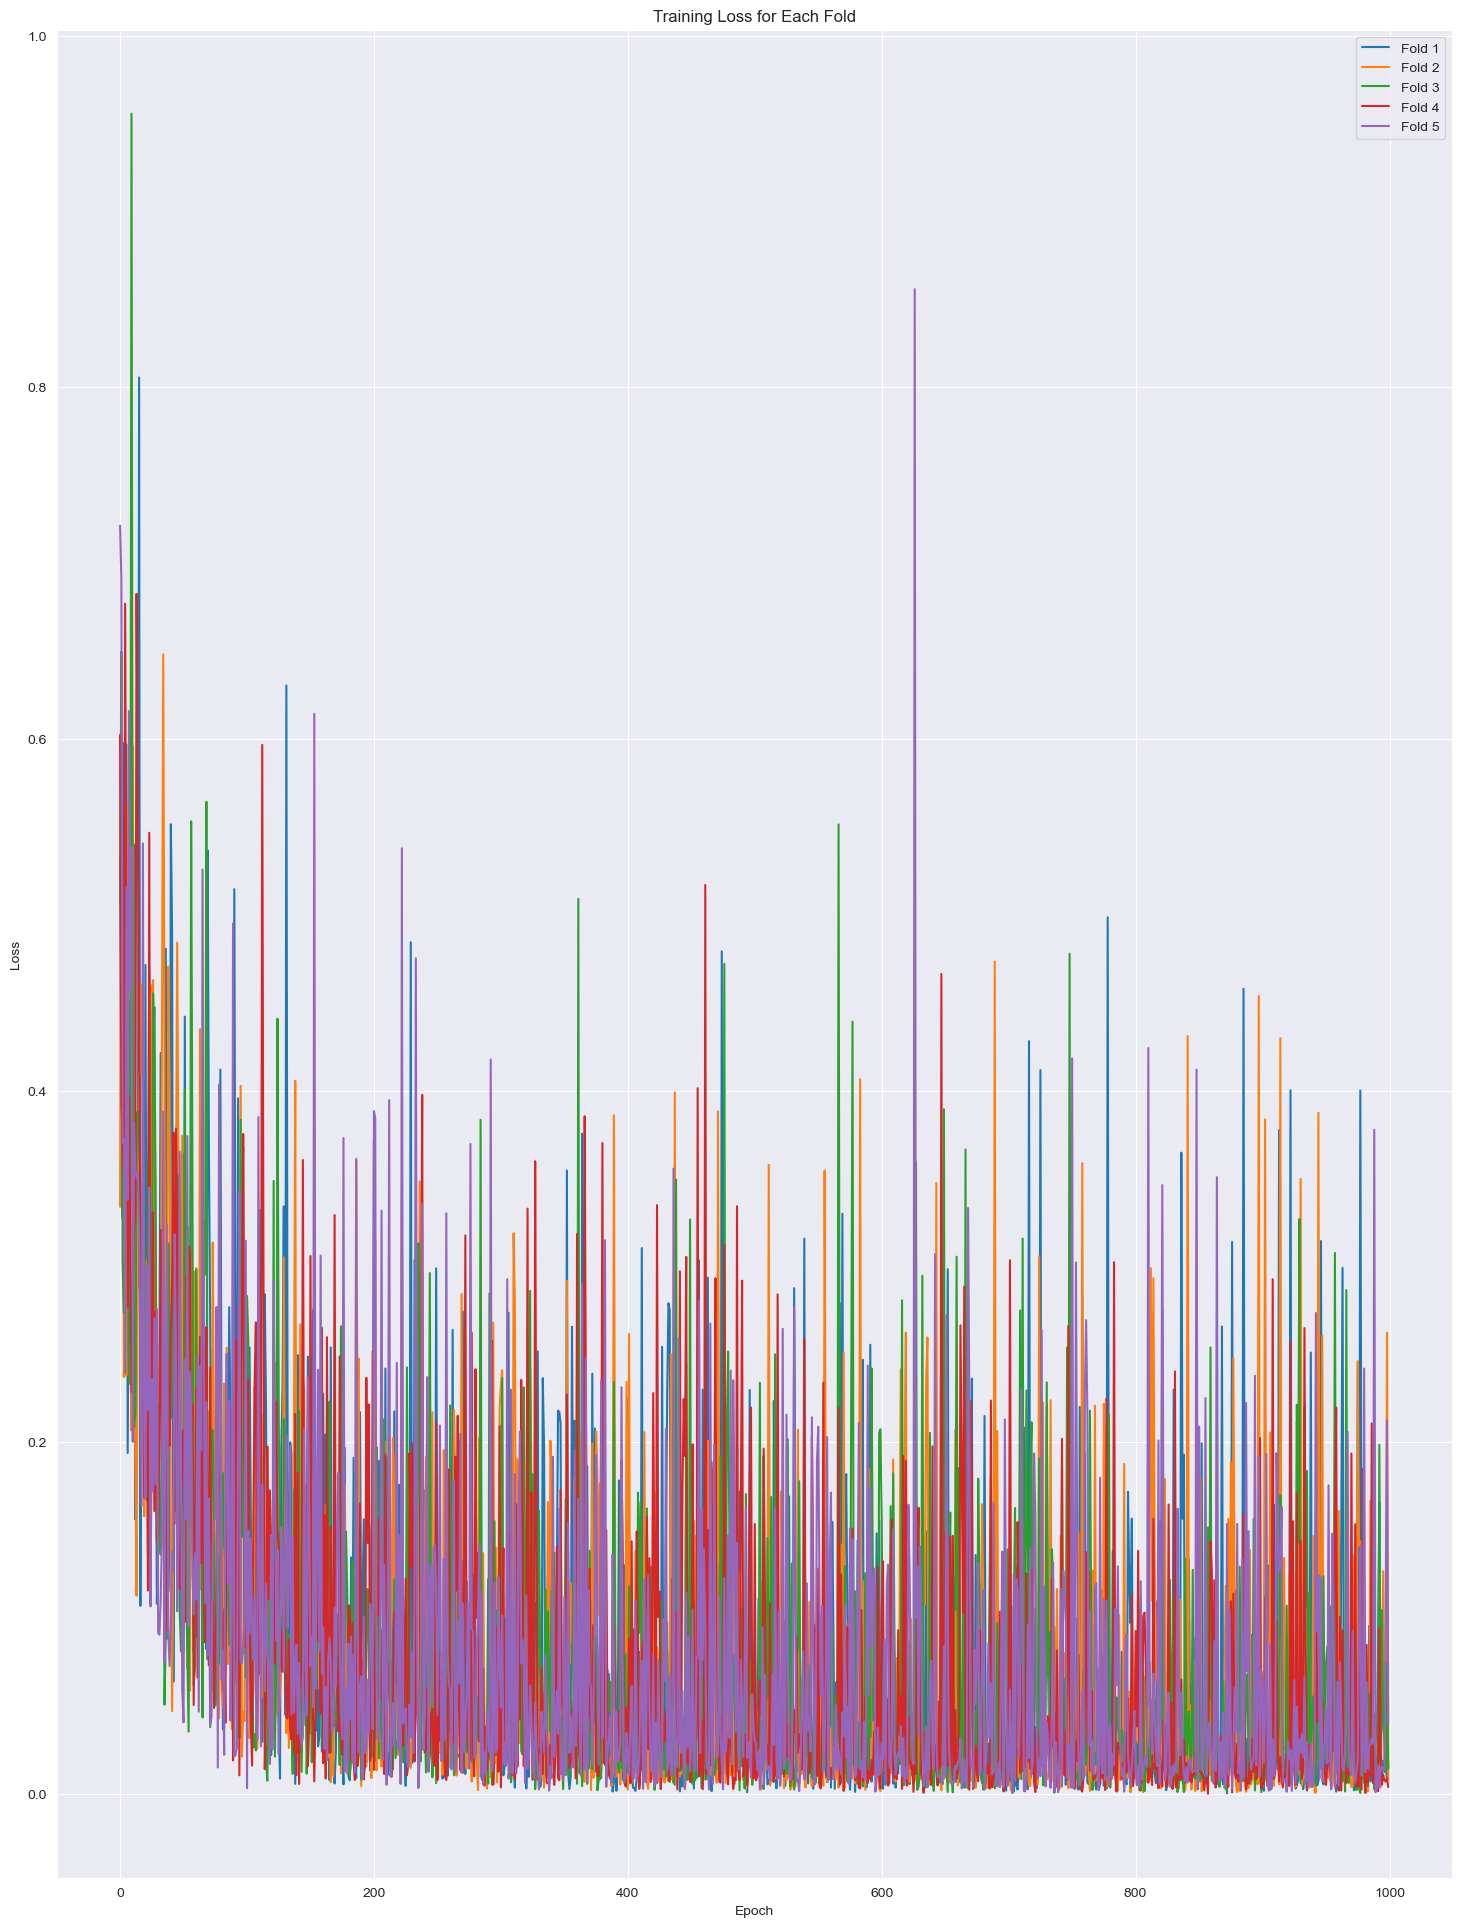

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchsummary import summary

# 检查GPU是否可用并设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
df = pd.read_csv('Resources/Data/Encoded_Resampled_HR_Analytics.csv')
X = df.drop('Attrition', axis=1)
y = df['Attrition'].values

# 检查并移除只有一个唯一值的列
for col in X.columns:
    if X[col].nunique() == 1:
        print(f"正在删除: {col}")
        X.drop(col, axis=1, inplace=True)

# 数据预处理
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 定义神经网络模型
class EnhancedNN(nn.Module):
    def __init__(self):
        super(EnhancedNN, self).__init__()
        self.fc1 = nn.Linear(31, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# 将模型移动到设备并显示模型摘要
model = EnhancedNN().to(device)
print("Model Summary:")
summary(model, input_size=(1, 31))

# 初始化K折交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1s = []
fold_roc_aucs = []
all_train_loss = []
current_fold = 0

for train_index, test_index in skf.split(X, y):
    current_fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 将数据转换为PyTorch张量并移动到设备
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

    model = EnhancedNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss = []
    for epoch in range(1000):
        for batch in train_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        train_loss.append(loss.item())
        print(f"Cuurent K-Fold: {current_fold}/5, Epoch {epoch+1}, Loss: {loss.item()}")

    all_train_loss.append(train_loss)

    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch in test_loader:
            X_batch, y_batch = batch
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(y_batch.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    fold_accuracies.append(accuracy)
    fold_f1s.append(f1)
    fold_roc_aucs.append(roc_auc)

print(f"Average Accuracy: {np.mean(fold_accuracies)}, Average F1 Score: {np.mean(fold_f1s)}, Average ROC AUC: {np.mean(fold_roc_aucs)}")

plt.figure(figsize=(18, 24))
for i, train_loss in enumerate(all_train_loss):
    plt.plot(train_loss, label=f"Fold {i+1}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Each Fold')
plt.legend()
plt.show()
